In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

good_patterns = [[1, 0, 0, 1]]
training_data_length = 1000

def getTrainingData(length, pattern_length):
    training_data = np.array([np.array([0, 1]).repeat(pattern_length / 2)] * length)
    
    for pattern in training_data:
        np.random.shuffle(pattern)   
    
    return training_data

def getCorrectResults(patterns):
    return np.array([1 if list(pattern) in good_patterns else 0 for pattern in patterns])

training_data = getTrainingData(training_data_length, pattern_length=4)
correct_results_training_data = getCorrectResults(training_data)

In [36]:
# class to pass to model.fit() as callback, that will record the losses after each batch
class TrainingHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))

    def plot(self):
        plt.figure(figsize=(12, 8))

        # Loss
        plt.subplot(2, 1, 1)
        plt.plot(self.losses, label="Loss")
        plt.yscale("log")
        plt.ylabel("Loss")
        plt.xlabel("Batch")
        plt.title("Loss by Batch")

        # Accuracy
        plt.subplot(2, 1, 2)
        plt.plot(self.accuracies, label="accuracy")

        plt.ylabel("Accuracy")
        plt.xlabel("Batch")
        plt.title("Accuracy by Batch")

        plt.tight_layout()
        plt.show()


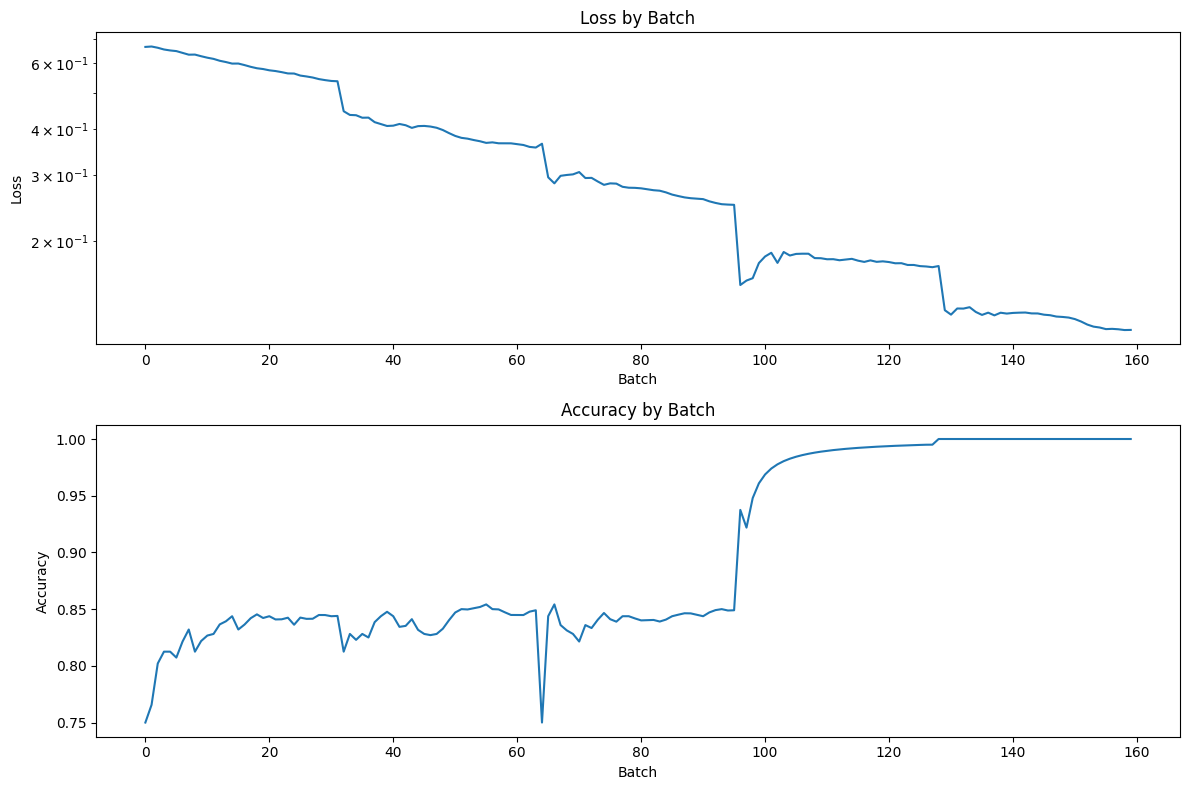

first_perfect_batch=128, translates to epoche 4.096


In [37]:
# für Aufgabe 4d), wir varieeren die Anzahl der Layer
use_extra_layer = True

NN = keras.Sequential()
NN.add(keras.Input(shape=(4,)))
if use_extra_layer:
    NN.add(keras.layers.Dense(128, activation="relu"))
NN.add(keras.layers.Dense(1, activation="sigmoid"))    # sigmoid(x) = 1 / (1 + exp(-x)) here

NN.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

training_history = TrainingHistory()
NN.fit(training_data, correct_results_training_data, epochs=5, callbacks=[training_history], verbose=0, batch_size=32)
training_history.plot()

try:
    first_perfect_batch = np.where(np.array(training_history.accuracies) == 1.0)[0][0]
    print(f"{first_perfect_batch=}, translates to epoche {32 / training_data_length * first_perfect_batch}")
except IndexError:
    print("no perfect batch found")

# print the weights only if there are not too many due to the extra layer
if not use_extra_layer:
    weights = NN.get_weights()
    print("Weights:")
    for i, layer_weights in enumerate(weights):
        print(f"Layer {i}:")
        for j, weight in enumerate(layer_weights):
            print(f"Weight {j}: {weight}")

Now we test the Network with a new list of patterns.

In [38]:
test_data = np.copy(training_data)
np.random.shuffle(test_data)

# NN.predict returns an array with shape=(trainging_data_length = 1000, output_neurons = 1) 
# so we flatten it to get a 1D array with our predictions
results_on_test_data = NN.predict(test_data).flatten() 
correct_results_test_data = getCorrectResults(test_data)

all_correct = np.array_equal(correct_results_test_data, np.round(results_on_test_data))
max_difference = max(abs(results_on_test_data - correct_results_test_data))
print(f"all test data correct, when rounded: {all_correct}")
print(f"maximum difference from correct result: {max_difference}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
all test data correct, when rounded: True
maximum difference from correct result: 0.2654692530632019


Aufgabe 4e


In [39]:
good_patterns = [
    list(np.array(list(zip(np.ones(32), np.zeros(32)))).flatten()),
    list(np.array(list(zip(np.zeros(32), np.ones(32)))).flatten())
]

training_data_length = 20_000

def getTrainingData(length, pattern_length):
    training_data = np.array([np.array([0, 1]).repeat(pattern_length / 2)] * length)
    
    for i, pattern in enumerate(training_data):
        # this time we additionally inject some good patterns, 
        # because otherwise there wouldnt be enough good patterns in training_data
        rand = np.random.rand()
        if rand < 0.2:
            training_data[i] = np.array(good_patterns[0], dtype=int)
        elif rand < 0.4:
            training_data[i] = np.array(good_patterns[0], dtype=int)
        else: 
            np.random.shuffle(pattern) # shuffle in place, pattern is still the actual element from the training_data array
    
    return training_data

training_data = getTrainingData(training_data_length, pattern_length=64)
correct_results_training_data = getCorrectResults(training_data)

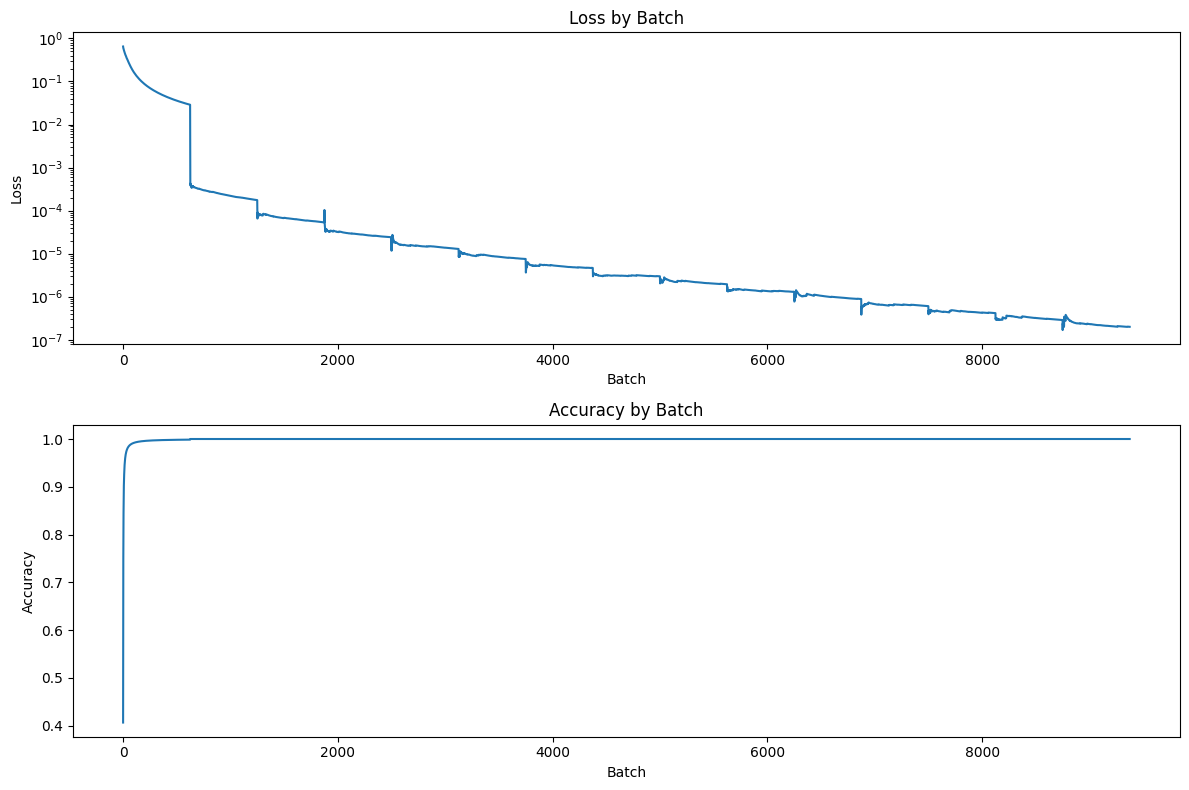

In [40]:
NN = keras.Sequential()
NN.add(keras.Input(shape=(64,)))
NN.add(keras.layers.Dense(32, activation="relu"))
NN.add(keras.layers.Dense(16, activation="relu"))
NN.add(keras.layers.Dense(1, activation="sigmoid"))

NN.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

training_history = TrainingHistory()
NN.fit(training_data, correct_results_training_data, epochs=15, callbacks=[training_history], verbose=0)
training_history.plot()

In [48]:
test_data = getTrainingData(length=500_000, pattern_length=64)

results_on_test_data = NN.predict(test_data).flatten()
correct_results_test_data = getCorrectResults(test_data)

all_correct = np.array_equal(correct_results_test_data, np.round(results_on_test_data))
max_difference = max(abs(results_on_test_data - correct_results_test_data))

print(f"all test data correct, when rounded: {all_correct}")
print(f"maximum difference from correct result: {max_difference}")


# test a pattern that is almost correct: 
almost_good_pattern = np.copy(good_patterns[0])
almost_good_pattern[0], almost_good_pattern[1] = almost_good_pattern[1], almost_good_pattern[0]

result_for_almost_good_pattern = NN.predict(np.array([almost_good_pattern], dtype=int)).flatten()[0]

print(f"{almost_good_pattern=}\n{result_for_almost_good_pattern=}")

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 14s 862us/step
all test data correct, when rounded: True
maximum difference from correct result: 0.004440410528331995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
almost_good_pattern=array([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
result_for_almost_good_pattern=0.999978


We can see from the almost_good_pattern, that the network is far from solving everything correctly, even though it works fairly well on a few thousand random test examples.